# Supernovae Analysis with Markov Chain Monte Carlo

### Abstract

In this project we will use the Pantheon+SH0ES luminosity distances data of 1701 Supernovae to estimate cosmological parameters. The parameters that we are interested in are the Hubble constant $H_0$, the matter density $\Omega_m$ and the radiation density $\Omega_r$. The bayesian statistics will be adopted to calculate the posterior probability distribution of the parameters given the experimental supernovae distances, which will be used to determine the likelihood function. We will implement the emcee algorithm to generate samples with a Markov Chain Monte Carlo (MCMC) model and use the posterior probability distribution. Finally, the results will be plotted in the space of parameters.

# Installing emcee

First we will install the most recently version of [emcee](https://emcee.readthedocs.io/en/stable/) library and the package Corner for corner plots. The emcee is an MIT licensed pure-Python implementation of Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler that will be used to estimate the posterior probability function. 

In [230]:
#Installing the EMCEE - Markov Chain Monte Carlo library
!pip install -U emcee

In [231]:
# Installing the Corner plot module
! python -m pip install corner

In [125]:
# Setting interative plots in the notebook from matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [232]:
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from corner import corner
import sys

In [127]:
df = pd.read_table("/kaggle/input/supernovae-pantheonsh0es-data/PantheonSH0ES.dat", sep="\s+")

In [128]:
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [129]:
df.shape

(1701, 47)

Text(0, 0.5, 'Distance Modulus')

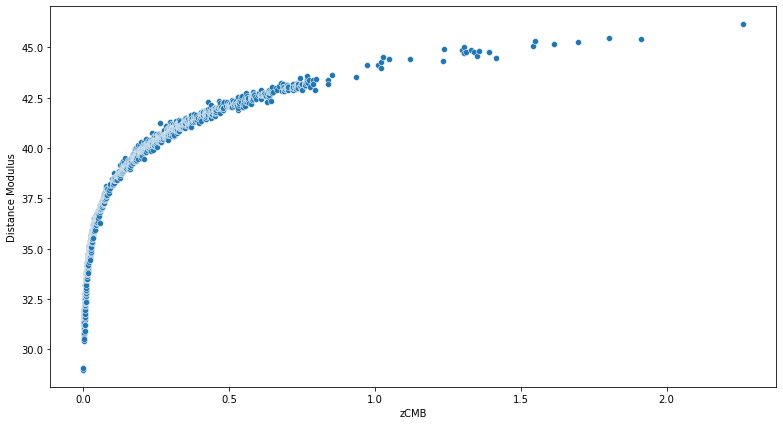

In [130]:
plt.figure(figsize=(13,7))
sns.scatterplot(x=df['zCMB'], y=df['MU_SH0ES'])
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

# Defining the Theoretical Model

In [131]:
# Importing the numerical integration package
from scipy.integrate import quad

In [132]:
# Defining the cosmological density parameters (just our first guess)
Omega_r_guess, Omega_m_guess, H0_guess, = 9*10**(-5), 0.31, 68/(3*10**19)
Omega_Lambda_guess = 1-Omega_r_guess-Omega_m_guess

In [174]:
# The function we want to integrate
def f(z, Omega_r, Omega_m, H0):
    Omega_Lambda = 1-Omega_r-Omega_m
    return 1/(np.sqrt(Omega_r*(1+z)**4+Omega_m*(1+z)**3+Omega_Lambda))

In [175]:
# call quad to numerical integrate f using quadrature method
L=[]
for z in np.arange(0.001, 2.5, 0.0014):
    res, err = quad(f, 0, z, args=(Omega_r_guess, Omega_m_guess, H0_guess)) # I discarted the integration error, but it can be stored
    L.append(res)
len(L)

1785

In [176]:
cLight = 3*10**8 # Speed of light in vacuum
dH = cLight/H0_guess # Hubble length in Mpc

In [177]:
# Calculating the luminosity distance
z_list=[]
for z in np.arange(0.001,2.5,0.0014):
    z_list.append(z)
dL=[]
for k in np.arange(0, 1785):
    dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
print(len(z_list))
print(len(dL))

1785
1785


In [178]:
mu_model=[]
for k in range(0, 1701):
    mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
len(mu_model)

1701

In [179]:
# The z_list array and the distance modulus must be the same length, so we will discard the remaining points
del z_list[1701:1785]
len(z_list)

1701

In [180]:
from scipy.interpolate import interp1d # Interpolation function

mu_model_inter = interp1d(z_list, mu_model, kind='cubic')


Text(0, 0.5, 'Theoretical Distance Modulus')

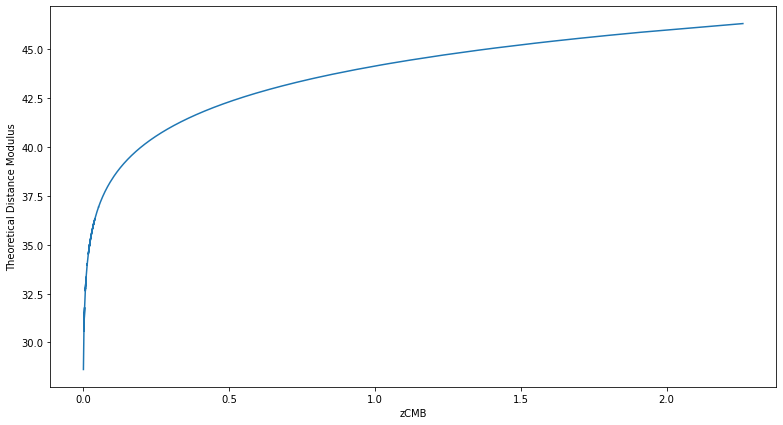

In [187]:
z_var = df['zCMB']
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_model_inter(z_var))
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

Text(0, 0.5, 'Distance Modulus')

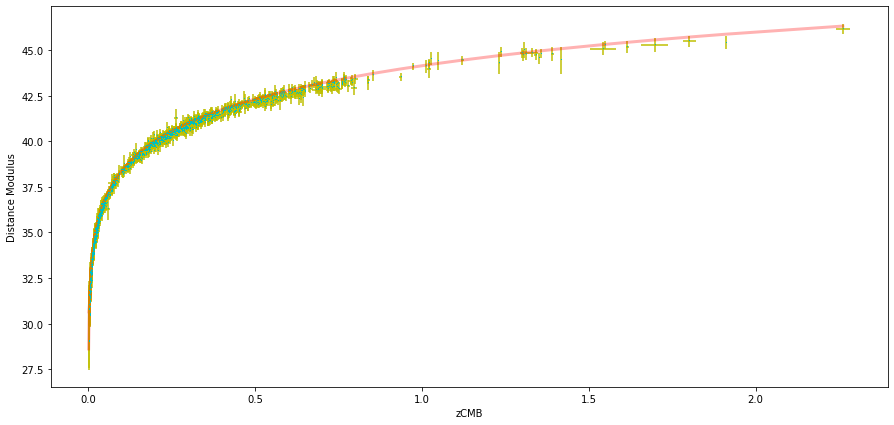

In [184]:
plt.figure(figsize=(15,7))
# Plot the error bars
x_exp=df['zCMB']
y_exp=df['MU_SH0ES']
plt.errorbar(x_exp, y_exp, xerr=df['zCMBERR'], yerr=df['MU_SH0ES_ERR_DIAG'], fmt=",c", ecolor="y", capsize=0)
# Plot the true line
y_theo=mu_model_inter
plt.plot(x_exp, y_theo(x_exp), "r", alpha=0.3, lw=3)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")

This is a comparison between theoretical and experimental distance modulos of 1701 supernovae. The error bars comes from the Pantheon+SH0ES data, the uncertainty on MU_SH0ES was determined from the diagonal of the covariance matrix and are only for plot purpose, cannot be used to fit cosmological parameters.

# Implementing the model in a pipeline

In [185]:
def mu_model_pipe(Omega_r, Omega_m, H0):
    L=[]
    for z in np.arange(0.001, 2.5, 0.0014):
        res, err = quad(f, 0, z, args=(Omega_r, Omega_m, H0)) # I discarted the integration error, but it can be stored
        L.append(res)
    cLight = 3*10**8 # Speed of light in vacuum
    dH = cLight/H0 # Hubble length in Mpc
    # Calculating the luminosity distance
    z_list=[]
    for z in np.arange(0.001,2.5,0.0014):
        z_list.append(z)
    dL=[]
    for k in np.arange(0, 1785):
        dL.append(dH*(1+z_list[k])*L[k]/(3*10**22))
    # Calculating the distance modulus
    mu_model=[]
    for k in range(0, 1701):
        mu_model.append((5*(np.log10(np.abs(dL[k])) + 5)))
    del z_list[1701:1785]
    mu_model_inter = interp1d(z_list, mu_model, kind='cubic')
    return mu_model_inter

In [188]:
mu_test = mu_model_pipe(Omega_r_guess, Omega_m_guess, H0_guess)

Text(0, 0.5, 'Theoretical Distance Modulus')

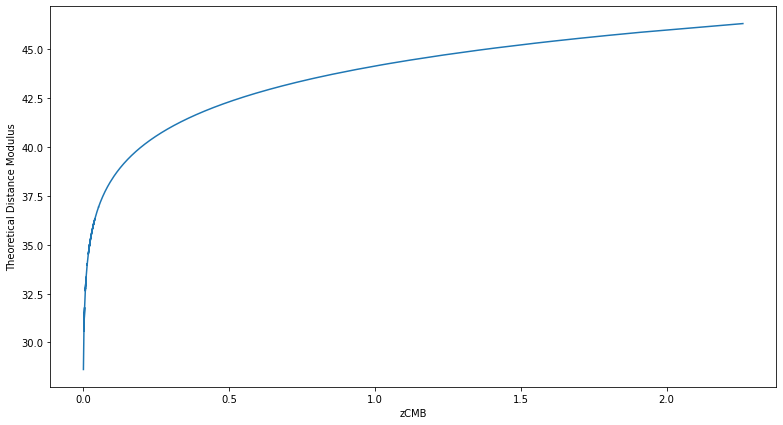

In [190]:
# Testing the mu_model_pipe function
plt.figure(figsize=(13,7))
plt.plot(z_var, mu_test(z_var))
plt.xlabel("zCMB")
plt.ylabel("Theoretical Distance Modulus")

# Importing the Covariance Matrix

The format of the covariance (.cov) file is NxN lines where the matrix should be read in sequentially.  The first line gives the number of rows/columns in the matrix (N=1701).  The STATONLY matrix has only elements that correspond to the statistical distance uncertainties for individual SNe. This includes intrinsic scatter off-diagonal components when the light-curves represent the same SN observed by different surveys.

In [191]:
cov_aux = pd.read_table('/kaggle/input/pantheon-cov-matrix/Pantheon%2BSH0ES_STAT%2BSYS.cov')
cov_aux.head()

,1701
0,0.031771
1,0.005754
2,0.000310
3,0.001187
4,0.000083


In [192]:
cov_aux.shape

(2893401, 1)

In [193]:
cov_matrix = []
for i in range(1701):
    row = []
    for j in range(1701*i,1701*(i+1)):
        row.append(cov_aux['1701'][j])
    cov_matrix.append(row)

In [194]:
len(cov_matrix)

1701

In [195]:
cov_matrix[0][0]

0.03177108

In [196]:
cov_matrix[1700][1700]==cov_aux['1701'][2893400] # Verifying if the matrix was with succes

True

In [197]:
cov_matrix = np.array(cov_matrix) # Converting the matrix list into a Numpy array format 
cov_matrix[0]

array([ 3.177108e-02,  5.754430e-03,  3.100600e-04, ...,  2.945500e-04,
       -8.595000e-05, -2.701100e-04])

In [198]:
inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
inv.shape

(1701, 1701)

In [199]:
det = np.linalg.det(cov_matrix) 
det

0.0

In [201]:
np.linalg.eig(cov_matrix)[1]

array([[-2.96148587e-03, -2.18443140e-02,  9.91981514e-04, ...,
         9.64893133e-04,  3.19053813e-04,  5.91684316e-05],
       [-1.72476998e-03,  1.90502948e-03, -1.45654135e-02, ...,
         5.69425676e-05, -5.51999401e-04, -3.43874555e-03],
       [-3.25782834e-02,  1.53065947e-02,  1.09858778e-02, ...,
         1.54613492e-03, -1.32184742e-03, -6.56669952e-03],
       ...,
       [-2.86966100e-02, -2.16020537e-02, -1.08898760e-03, ...,
        -1.15688499e-03,  2.78073191e-04, -2.23892355e-03],
       [-4.30813218e-02,  3.33182559e-03, -2.80048267e-03, ...,
        -1.28031502e-03,  2.56683754e-04, -9.61990704e-04],
       [-5.31572832e-02,  5.55188533e-03, -9.28158623e-03, ...,
        -4.79416272e-03,  1.30874885e-03, -2.37309350e-03]])

# Likelihood Distribution Calculation

In [215]:
def log_likelihood(theta, mu_data, cov):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    Omega_r, Omega_m, H0 = theta
    cov_inv = np.linalg.inv(cov)
    cov_eigvals = np.linalg.eig(cov)
    cov_len = len(cov)
    mu_model_array=[]
    mu_aux = mu_model_pipe(Omega_r, Omega_m, H0)
    for z in z_var:
        mu_model_array.append(mu_aux(z))
    mu_model_array=np.array(mu_model_array)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

In [217]:
# Testing the log_likelihood:
mu_data = np.array(df['MU_SH0ES'])
cov=cov_matrix
theta = (Omega_r_guess, Omega_m_guess, H0_guess)
log_likelihood(theta, mu_data, cov)

9514377.56627583

In [218]:
from scipy.optimize import minimize # Minimization of scalar function

mu_data = np.array(df['MU_SH0ES'])
cov = cov_matrix
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([Omega_r_guess, Omega_m_guess, H0_guess]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_data, cov))
Omega_r_ml, Omega_m_ml, H0_ml = soln.x

print("Maximum likelihood estimates:")
print("Omega_r = {0:.3f}".format(Omega_r_ml))
print("Omega_m = {0:.3f}".format(Omega_m_ml))
print("H0_ml = {0:.3f}".format(H0_ml))

Maximum likelihood estimates:
Omega_r = 0.050
Omega_m = 0.296
H0 = 0.065


In [219]:
soln.x

array([0.04976142, 0.29617357, 0.06476885])

# Posterior Probability Function

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo method. According to Bayes Theorem, the posterior probability is given by:
$$  p(\theta|\vec{x}) \propto p(\theta)\mathcal{L}(\vec{x}|\theta)\,, $$

where $\theta$ is the cosmological parameters vector, $\vec{x}$ the input data and $\mathcal{L}(\vec{x}|\theta)$ is the likelihood function.

In [220]:
# Defining the prior probability function

def log_prior(theta):
    Omega_m, Omega_r, H0 = theta # Initial parameters guess
    if 8.5*10**(-5) < Omega_r < 9.5*10**(-5) and 0.25 < Omega_m < 0.35 and 60/(3*10**19) < H0 < 75/(3*10**19):
        return 0.0
    return -np.inf

In [221]:
# Defining the full log-probability function

def log_probability(theta, mu_data, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mu_data, cov)

In [226]:
# Define the initial position
pos = soln.x + 1e-4 * np.random.randn(32, 3)  
nwalkers, ndim = pos.shape

In [234]:
# Generating samples with emcee
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mu_data, cov))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:02<00:00, 1838.70it/s]


# Plotting the Parameters Estimatitive

In [235]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["Omega_m", "Omega_r", "H_0"]

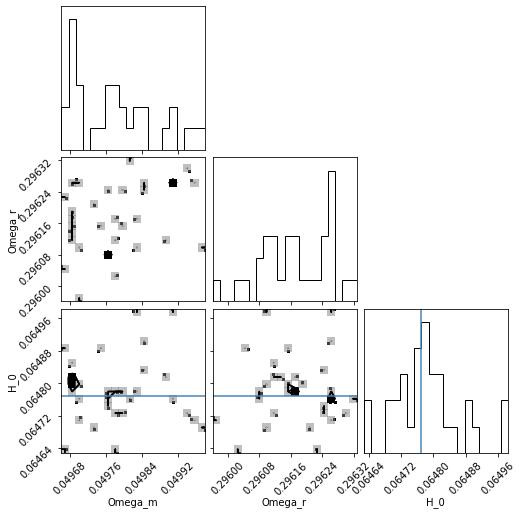

In [237]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[Omega_m_guess, Omega_r_guess, H0_guess]
);